RandomManager created with root seed 31.
All deterministic RNG streams created.

--- Common Setup ---
Shadowing map generated (identical for all topologies).
Placed 10 nodes randomly (positions identical for all topologies).

=== Random Connected ===
Constructed random links: total links = 18


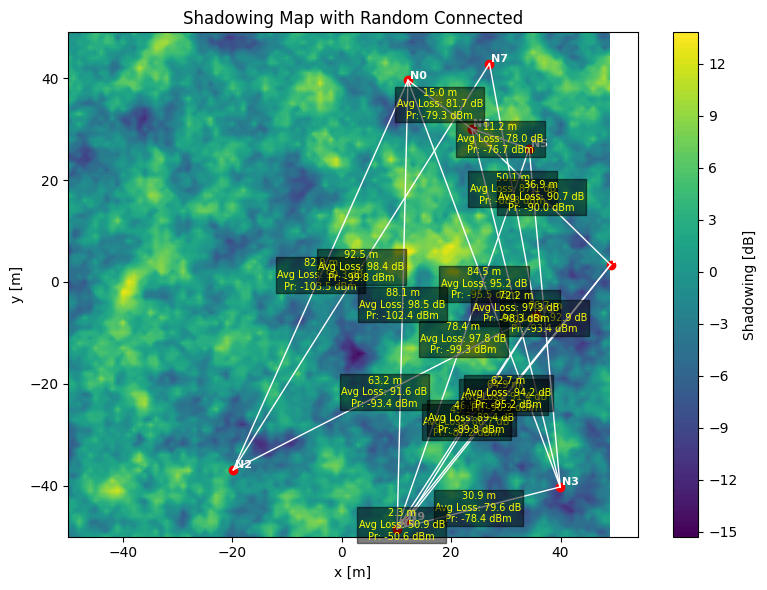

Shadowing stats: mean=-0.12 dB, std=3.96 dB (target 4 dB)

=== Star Topology ===
Constructed star links: total links = 9


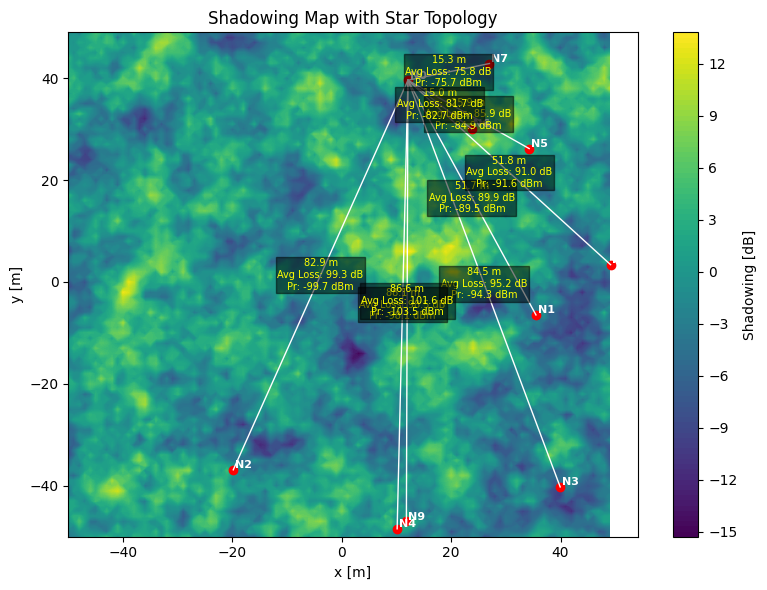

Shadowing stats: mean=-0.12 dB, std=3.96 dB (target 4 dB)

=== Tree Topology ===
Constructed tree links: total links = 9


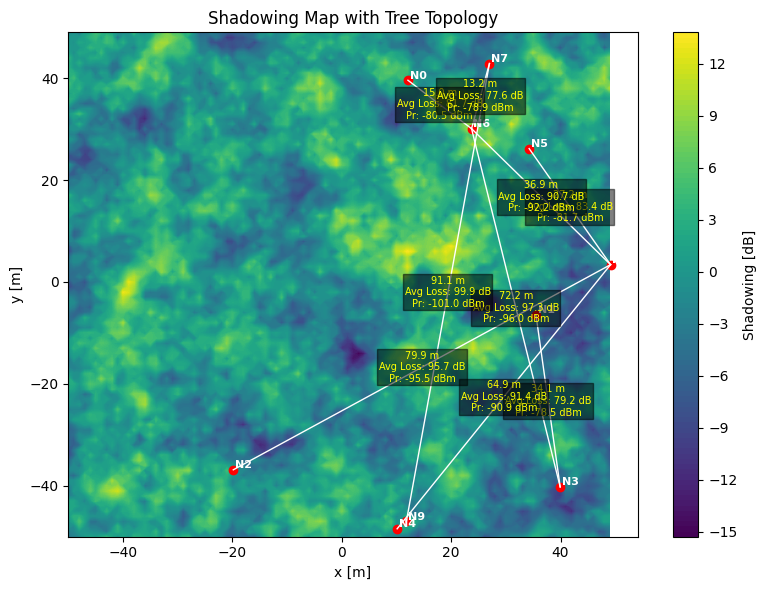

Shadowing stats: mean=-0.12 dB, std=3.96 dB (target 4 dB)

=== Ring Topology ===
Constructed ring links: total links = 10


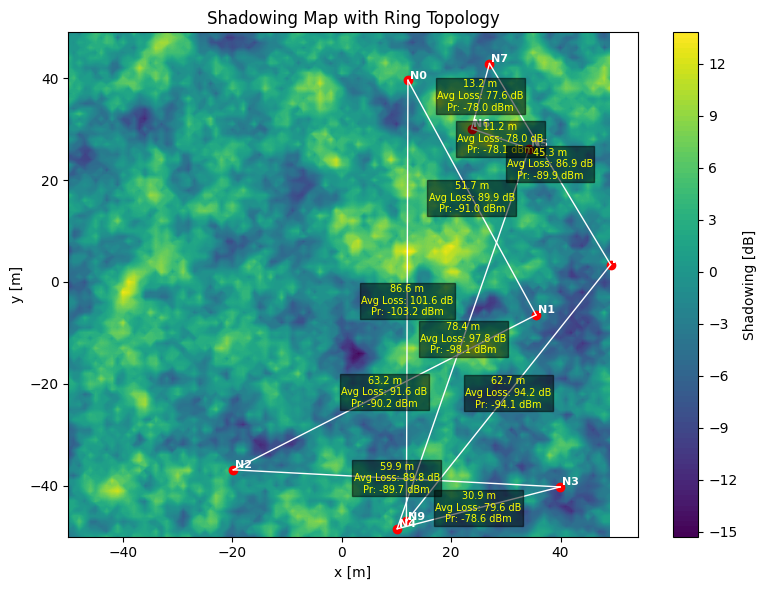

Shadowing stats: mean=-0.12 dB, std=3.96 dB (target 4 dB)

=== Line Topology ===
Constructed line links: total links = 9


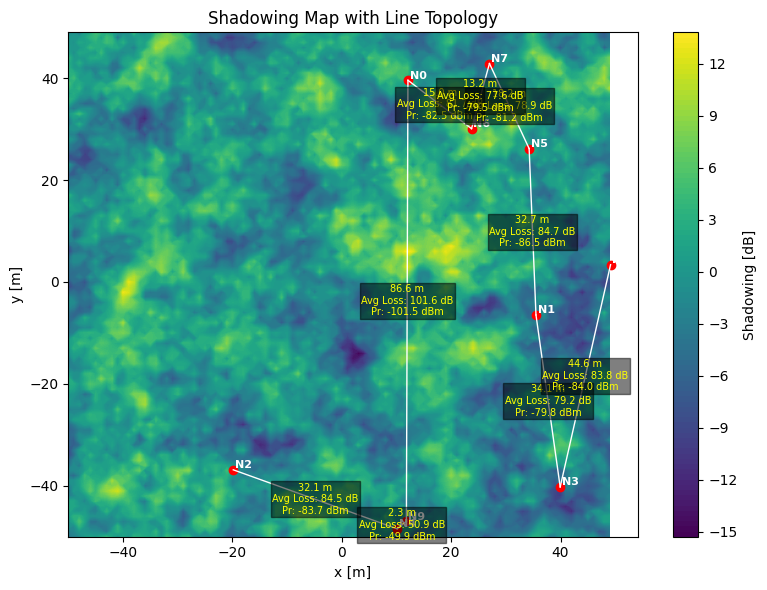

Shadowing stats: mean=-0.12 dB, std=3.96 dB (target 4 dB)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from typing import Dict


# Path import helper
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.insert(0, project_root)

from simulator.engine.topology import DSpace, CartesianCoordinate, Topology
from simulator.models.channelModel import ChannelModel
from simulator.engine.RandomManager import RandomManager


# === RandomManager Setup ===
ROOT_SEED = 31
rand_manager = RandomManager(root_seed=ROOT_SEED)
print(f"RandomManager created with root seed {ROOT_SEED}.")

# === Simulation parameters ===
dspace_step   = 1        # grid resolution [m]
dspace_npt    = 100      # 100×100 grid
freq          = 2.4e9    # signal frequency [Hz]
coh_d         = 5        # shadowing coherence distance [m]
shadow_dev    = 4        # shadowing std dev [dB]
pl_exponent   = 3        # path-loss exponent
d0            = 1        # ref distance [m]
fading_shape  = 10.0     # Nakagami m
n_points      = 10       # number of nodes
link_prob     = 0.2      # probability of extra random links

# === Topology configs ===
topo_configs = [
    {"name": "Random Connected", "type": "random"},
    {"name": "Star Topology",     "type": "star"},
    {"name": "Tree Topology",     "type": "tree"},
    {"name": "Ring Topology",     "type": "ring"},
    {"name": "Line Topology",     "type": "line"},
]

# === Create deterministic RNG streams ===
rand_manager.create_stream("shadowing")
rand_manager.create_stream("placement")
for cfg in topo_configs:
    rand_manager.create_stream(f'topology_{cfg["type"]}')
print("All deterministic RNG streams created.")

# Build topology helper unchanged
def build_topology(topo: Topology, ttype: str, rng: np.random.Generator):
    if ttype == "random":
        nodes = topo.node_ids.copy()
        rng.shuffle(nodes)
        for i in range(1, len(nodes)):
            u, v = nodes[i], rng.choice(nodes[:i])
            topo.add_link(u, v)
        for u in topo.node_ids:
            neigh = set(topo.get_neighbors(u))
            for v in topo.node_ids:
                if v > u and v not in neigh and rng.random() < link_prob:
                    topo.add_link(u, v)
    elif ttype == "star":
        center = topo.node_ids[0]
        for other in topo.node_ids:
            if other != center:
                topo.add_link(center, other)
    elif ttype == "tree":
        nodes = topo.node_ids.copy()
        rng.shuffle(nodes)
        for i in range(1, len(nodes)):
            u, v = nodes[i], rng.choice(nodes[:i])
            topo.add_link(u, v)
    elif ttype == "ring":
        ids = topo.node_ids
        for i in range(len(ids)):
            u, v = ids[i], ids[(i+1) % len(ids)]
            topo.add_link(u, v)
    elif ttype == "line":
        sorted_nodes = sorted(topo.node_ids, key=lambda nid: topo.get_node_coordinate(nid).x)
        for i in range(len(sorted_nodes)-1):
            u, v = sorted_nodes[i], sorted_nodes[i+1]
            topo.add_link(u, v)
    else:
        raise ValueError(f"Unknown topology type: {ttype}")

# === Unified setup ===
print("\n--- Common Setup ---")

shadow_rng = rand_manager.get_stream("shadowing")
dspace = DSpace(dspace_step=dspace_step, dspace_npt=dspace_npt)

model = ChannelModel(
    rng=shadow_rng,
    dspace=dspace, freq=freq, coh_d=coh_d,
    shadow_dev=shadow_dev, pl_exponent=pl_exponent,
    d0=d0, fading_shape=fading_shape
)
model.generate_shadowing_map()
print("Shadowing map generated (identical for all topologies).")

placement_rng = rand_manager.get_stream("placement")
raw_pts = placement_rng.uniform(-dspace._size/2, dspace._size/2, size=(n_points, 2))
print(f"Placed {n_points} nodes randomly (positions identical for all topologies).")

# === Main loop for each topology ===
for cfg in topo_configs:
    name, ttype = cfg["name"], cfg["type"]
    print(f"\n=== {name} ===")

    topo = Topology()
    for idx, (x, y) in enumerate(raw_pts):
        coord = CartesianCoordinate(np.float64(x), np.float64(y))
        topo.add_node(node_id=idx, coordinate=coord)

    build_rng = rand_manager.get_stream(f"topology_{ttype}")
    build_topology(topo, ttype, build_rng)
    total_links = sum(len(topo.get_neighbors(n)) for n in topo.node_ids) // 2
    print(f"Constructed {ttype} links: total links = {total_links}")

    # Plot shadowing map + topology + label distances and losses (using fading-inc. link budget)
    fig, ax = plt.subplots(figsize=(8,6))
    cs = ax.contourf(dspace.X, dspace.Y, model.shadowing_map, levels=100, cmap='viridis')
    ax.set_title(f"Shadowing Map with {name}")
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    for node_id in topo.node_ids:
        P = topo.get_node_coordinate(node_id)
        ax.plot(P.x, P.y, 'ro')
        ax.text(P.x + 0.3, P.y + 0.3, f"N{node_id}", color='white', fontsize=8, weight='bold')

    seen = set()
    for u in topo.node_ids:
        for v in topo.get_neighbors(u):
            if (v,u) in seen:
                continue
            seen.add((u,v))
            A, B = topo.get_node_coordinate(u), topo.get_node_coordinate(v)
            ax.plot([A.x, B.x], [A.y, B.y], 'w-', linewidth=1)
            distance = dspace.distance(A, B)
            Pr_dBm = model.link_budget(A, B, Pt_dBm=0.0)  # TX = 0 dBm reference
            avg_loss_dB = model.total_loss_dB(A, B)  # define loss as positive number relative to 0 dBm TX
            mx, my = (A.x + B.x)/2, (A.y + B.y)/2
            ax.text(mx, my,
                    f"{distance:.1f} m\nAvg Loss: {avg_loss_dB:.1f} dB\nPr: {Pr_dBm:.1f} dBm",
                    color='yellow', fontsize=7, ha='center', va='center',
                    bbox=dict(facecolor='black', alpha=0.5, pad=1))

    fig.colorbar(cs, ax=ax, label='Shadowing [dB]')
    plt.tight_layout()
    plt.show()

    mean_sh = model.shadowing_map.mean()
    std_sh = model.shadowing_map.std()
    print(f"Shadowing stats: mean={mean_sh:.2f} dB, std={std_sh:.2f} dB (target {shadow_dev} dB)")

